<a href="https://colab.research.google.com/github/adityasingh1993/ML-DL-AI-LearnAndTry/blob/main/LLM/PEFT%2BLORA%2BQLORA_MistralAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install bitsandbytes trl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 MB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.9/310.9 kB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 22.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible

In [ ]:
!nvidia-smi

Sun Nov 17 03:04:45 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0              44W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [ ]:
# !huggingface-cli login

In [ ]:
!ls

JEOPARDY_CSV.csv.zip  sample_data


In [ ]:
# !unzip JEOPARDY_CSV.csv.zip

In [ ]:
import pandas as pd
import seaborn as sns
import datasets
from datasets import Dataset, DatasetDict
import json
import os
import torch
from pprint import pprint
import bitsandbytes as bnb
from huggingface_hub import notebook_login
from trl import SFTConfig, SFTTrainer, DataCollatorForCompletionOnlyLM
from peft import LoraConfig, PeftConfig, PeftModel, get_peft_model, prepare_model_for_kbit_training
from transformers import AutoConfig,AutoModel, AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

In [ ]:
df=pd.read_csv("Financial-QA-10k.csv")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   question  6998 non-null   object
 1   answer    6998 non-null   object
 2   context   6999 non-null   object
 3   ticker    7000 non-null   object
 4   filing    7000 non-null   object
dtypes: object(5)
memory usage: 273.6+ KB


In [ ]:
df.head(2)

,question,answer,context,ticker,filing
0,What area did NVIDIA initially focus on before...,NVIDIA initially focused on PC graphics.,"Since our original focus on PC graphics, we ha...",NVDA,2023_10K
1,What are some of the recent applications of GP...,Recent applications of GPU-powered deep learni...,Some of the most recent applications of GPU-po...,NVDA,2023_10K


<ipython-input-9-9f8e0591c041>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df["question"].str.len())


<Axes: xlabel='question', ylabel='Density'>

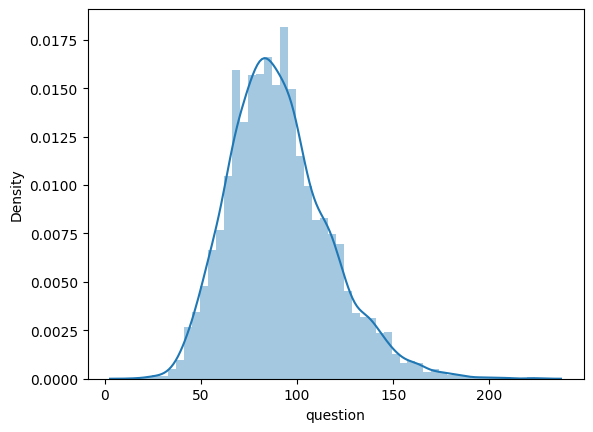

In [ ]:
sns.distplot(df["question"].str.len())

<ipython-input-10-ddeb45a92645>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df["answer"].str.len())


<Axes: xlabel='answer', ylabel='Density'>

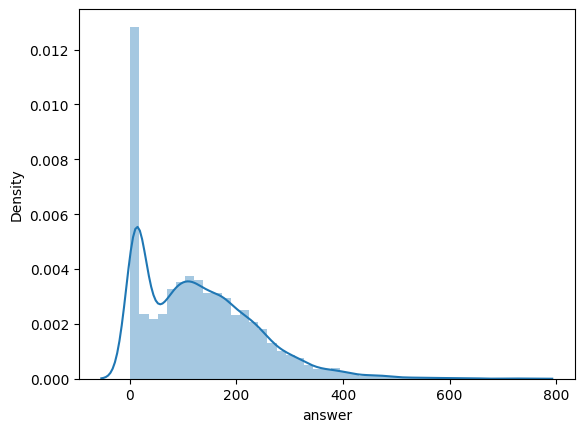

In [ ]:
sns.distplot(df["answer"].str.len())

<ipython-input-11-a048cc929c9d>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df["context"].str.len())


<Axes: xlabel='context', ylabel='Density'>

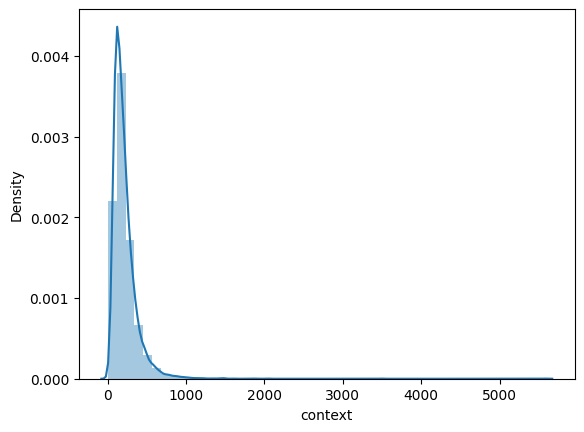

In [ ]:
sns.distplot(df["context"].str.len())

<Axes: xlabel='ticker', ylabel='count'>

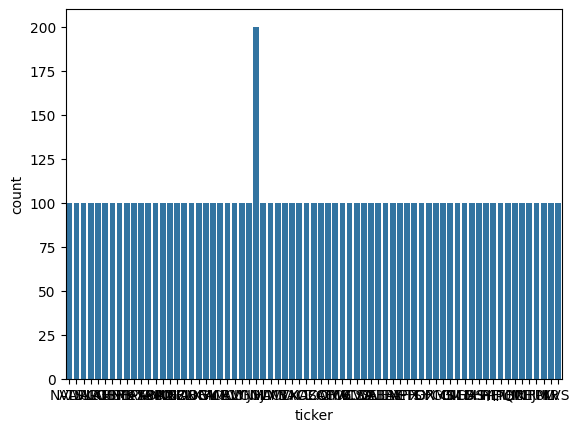

In [ ]:
sns.countplot(data=df,x='ticker')


In [ ]:
# df[' Category'].value_counts()

In [ ]:
dataset_pd=pd.DataFrame()
dataset_pd.dropna(inplace=True)
dataset_pd["input"]=df["question"]
dataset_pd["text"]=df["answer"]

dataset_pd["combine"]="[INST]"+df["context"]+df["question"]+"[/INST]"+df["answer"]+" </s>\n"

<Axes: xlabel='combine', ylabel='Count'>

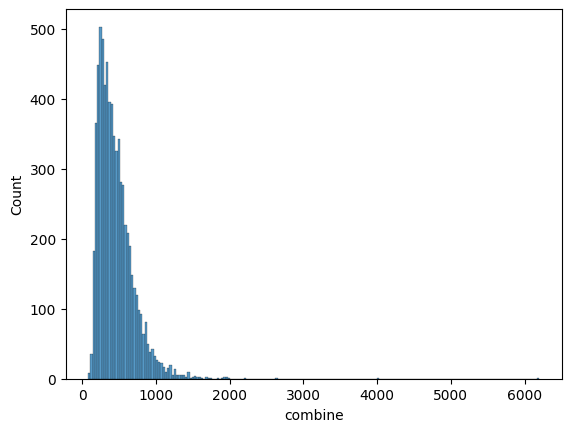

In [ ]:
sns.histplot(dataset_pd["combine"].str.len())

In [ ]:
model_name="intfloat/e5-mistral-7b-instruct"
# modle_name="facebook/opt-350m"

In [ ]:
bnb_config=BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type='nf4',
    bnb_4bit_compute_dtype=torch.torch.bfloat16
)

In [ ]:
model=AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map='auto',
    trust_remote_code=True,
    quantization_config=bnb_config
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of MistralForCausalLM were not initialized from the model checkpoint at intfloat/e5-mistral-7b-instruct and are newly initialized: ['lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
next(model.children())

MistralModel(
  (embed_tokens): Embedding(32000, 4096, padding_idx=2)
  (layers): ModuleList(
    (0-31): 32 x MistralDecoderLayer(
      (self_attn): MistralSdpaAttention(
        (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
        (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
        (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
        (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
        (rotary_emb): MistralRotaryEmbedding()
      )
      (mlp): MistralMLP(
        (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
        (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
        (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
        (act_fn): SiLU()
      )
      (input_layernorm): MistralRMSNorm((4096,), eps=1e-05)
      (post_attention_layernorm): MistralRMSNorm((4096,), eps=1e-05)
    )
  )
  (norm): MistralRM

In [ ]:
tokenizer=AutoTokenizer.from_pretrained(model_name)


In [ ]:
# tokenizer.pad_token=tokenizer.eos_token
tokenizer.padding_side = 'right'
tokenizer.pad_token = tokenizer.eos_token
tokenizer.add_eos_token = True
tokenizer.add_bos_token, tokenizer.add_eos_token

(True, True)

In [ ]:
model= prepare_model_for_kbit_training(model)

In [ ]:
model

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096, padding_idx=2)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralSdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm

In [ ]:
next(model.children())

MistralModel(
  (embed_tokens): Embedding(32000, 4096, padding_idx=2)
  (layers): ModuleList(
    (0-31): 32 x MistralDecoderLayer(
      (self_attn): MistralSdpaAttention(
        (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
        (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
        (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
        (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
        (rotary_emb): MistralRotaryEmbedding()
      )
      (mlp): MistralMLP(
        (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
        (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
        (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
        (act_fn): SiLU()
      )
      (input_layernorm): MistralRMSNorm((4096,), eps=1e-05)
      (post_attention_layernorm): MistralRMSNorm((4096,), eps=1e-05)
    )
  )
  (norm): MistralRM

In [313]:
from peft import LoraConfig
lora_alpha=16
lora_dropout=0.2
lora_r=32
peft_config=LoraConfig(
    lora_alpha=lora_alpha,
    r=lora_r,
    lora_dropout=lora_dropout,
    bias="none",
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head",
    ]


)

In [314]:
from transformers import TrainingArguments
output_dir="./result4"
per_device_train_batch_size=4
gradient_accumulation_steps=4
optim="paged_adamw_32bit"
save_steps=10
logging_steps=10
learning_rate=0.0002
max_grad_norm=0.2
max_steps=80
warmup_ratio=0.03
lr_scheduler_type='constant'



In [315]:
train_args=TrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    fp16=False,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=True,
    # evaluation_strategy='steps',
    # eval_steps=10,
    lr_scheduler_type=lr_scheduler_type,


)

In [316]:
def formatting_prompts_func(example):
    output_texts = []
    for i in range(len(example['input'])):
        text = f"### Human: {example['input'][i]}\n ### Assistant: {example['text'][i]}"
        output_texts.append(text)
    return output_texts

In [317]:
dataset_pd.dropna(inplace=True)

In [318]:
dataset_pd.head(2)

,input,text,combine
0,What area did NVIDIA initially focus on before...,NVIDIA initially focused on PC graphics.,"[INST]Since our original focus on PC graphics,..."
1,What are some of the recent applications of GP...,Recent applications of GPU-powered deep learni...,[INST]Some of the most recent applications of ...


In [319]:
dataset_hf=Dataset.from_pandas(dataset_pd[["combine"]].rename(columns={"combine":"text"}))

In [320]:
# dataset_hf=datasets.load_dataset("mlabonne/guanaco-llama2-1k")

In [321]:

dataset_hf_splited=dataset_hf

In [322]:
instruction_template = "###Human: "
response_template = "###Assistant: "
collator = DataCollatorForCompletionOnlyLM(instruction_template=instruction_template,response_template=response_template, tokenizer=tokenizer)

/usr/local/lib/python3.10/dist-packages/trl/trainer/utils.py:134: UserWarning: The pad_token_id and eos_token_id values of this tokenizer are identical. If you are planning for multi-turn training, it can result in the model continuously generating questions and answers without eos token. To avoid this, set the pad_token_id to a different value.
  warnings.warn(


In [323]:
from trl import SFTTrainer

In [324]:
# model.to("cuda:0")

In [325]:
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset_hf_splited,
    # eval_dataset=dataset_hf_splited["test"],
    peft_config=peft_config,
    dataset_text_field='text',
    max_seq_length=512,
    tokenizer=tokenizer,
    # formatting_func=formatting_prompts_func,
    # data_collator=collator,
    # data_collator=collator,
    args=train_args,
    packing=False
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': dataset_text_field, max_seq_length. Will not be supported from version '0.13.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:300: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:328: UserWarning: You passed a `dataset_text_field` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/6997 [00:00<?, ? examples/s]

max_steps is given, it will override any value given in num_train_epochs


In [326]:
import wandb
import os

In [327]:
trainer.accelerator

In [328]:
# trainer.data_collator.response_template

In [329]:
trainer.data_collator

DataCollatorForLanguageModeling(tokenizer=LlamaTokenizerFast(name_or_path='intfloat/e5-mistral-7b-instruct', vocab_size=32000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '</s>', 'additional_special_tokens': ['<unk>', '<s>', '</s>']}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	0: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}, mlm=False, mlm_probability=0.15, pad_to_multiple_of=None, tf_experimental_compile=False, return_tensors='pt')

In [330]:
os.environ["WANDB_PROJECT"]="Peft Train"

In [331]:
# df[df["question"].isin("comodity derivative framework")]

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss
